In [1]:
import pandas as pd 
import glob
import csv
import seaborn as sns

## Loading data

# To read and append raw files
file_paths = glob.glob('data/' + '*.csv')
print((len(file_paths)))
combined_data = pd.DataFrame()
for file_path in file_paths:
    if 'asos_dataset' not in file_path:
        df = pd.read_csv(file_path)
        combined_data = combined_data.append(df, ignore_index=True)

combined_data.head(10)

In [2]:
# To read combined file, lineterminator needs to be on due to some weird encoding.
df = pd.read_csv('data/asos_dataset.csv', encoding='utf-8',
                 lineterminator='\n')

## Exploring data

In [4]:
len(df)

114713

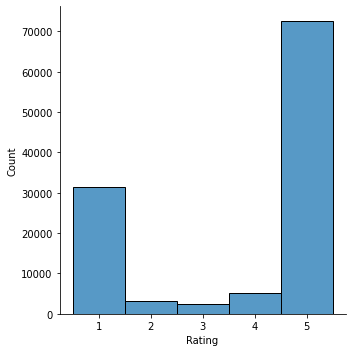

In [72]:
sns.displot(df, x="Rating", discrete=True)


In [3]:

from top2vec import Top2Vec
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

#model = Top2Vec(documents=newsgroups.data, speed="learn", workers=8)


AttributeError: module 'lib' has no attribute 'OpenSSL_add_all_algorithms'

In [79]:
newsgroups

NameError: name 'newsgroups' is not defined